In [1]:
# === Shared setup (run once at top) ===
from pathlib import Path
import pandas as pd, numpy as np, cv2, os, random, time

ROOT    = Path(r"C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection")
RAW_DIR = ROOT / "data" / "raw_images"          # has 0..9 subfolders
WORK    = ROOT / "workspace"
CROPS_DIR = WORK / "crops_128"                   # normalized crops saved here
SPLITS  = WORK / "splits"
MODELS  = ROOT / "models"
IMG_SIZE = (128,128)                             # (W,H)
RNG_SEED = 42

for d in [WORK, CROPS_DIR, SPLITS, MODELS]: d.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)


ROOT: C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection


In [2]:
import os, cv2, json, shutil, numpy as np, pandas as pd
from pathlib import Path

In [8]:
# ---Quality filtering (blurry/dark) ---
import shutil

def blur_score(img_bgr):
    return cv2.Laplacian(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY), cv2.CV_64F).var()

def too_dark(img_bgr, thresh=18):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    return gray.mean() < thresh

KEEP_DIR = WORK/"crops_128_clean"
if KEEP_DIR.exists(): shutil.rmtree(KEEP_DIR)
KEEP_DIR.mkdir(parents=True, exist_ok=True)

kept, dropped = 0, 0
for cls_dir in sorted(CROPS_DIR.glob("*")):
    if not cls_dir.is_dir(): continue
    out_cls = KEEP_DIR/cls_dir.name
    out_cls.mkdir(parents=True, exist_ok=True)
    for p in cls_dir.glob("*"):
        img = cv2.imread(str(p))
        if img is None: dropped += 1; continue
        if blur_score(img) < 40 or too_dark(img):
            dropped += 1; continue
        shutil.copy2(p, out_cls/p.name)
        kept += 1

print(f"Kept {kept}, dropped {dropped}. Clean crops ->", KEEP_DIR)


Kept 1716, dropped 1. Clean crops -> C:\Users\sayu\Desktop\Sign_Language\RealTimeObjectDetection\workspace\crops_128_clean


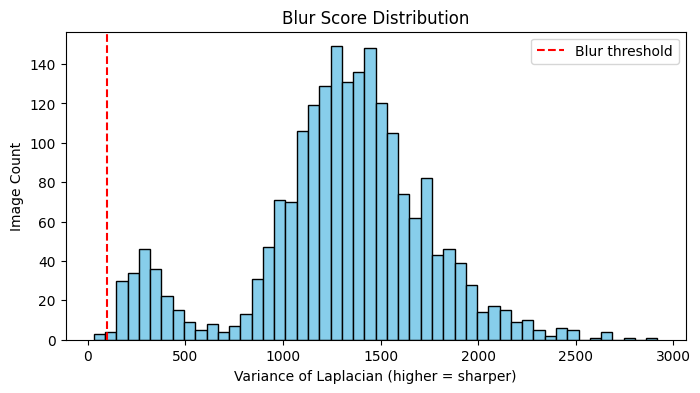

In [13]:
import cv2
import matplotlib.pyplot as plt

# Function to calculate blur score using Variance of Laplacian
def score(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# Compute blur scores for your dataset
blur_scores = [score(cv2.imread(r.path)) for _, r in manifest.iterrows()]

# Plot histogram
plt.figure(figsize=(8,4))
plt.hist(blur_scores, bins=50, color="skyblue", edgecolor="black")
plt.axvline(100, color="red", linestyle="--", label="Blur threshold")
plt.title("Blur Score Distribution")
plt.xlabel("Variance of Laplacian (higher = sharper)")
plt.ylabel("Image Count")
plt.legend()
plt.show()


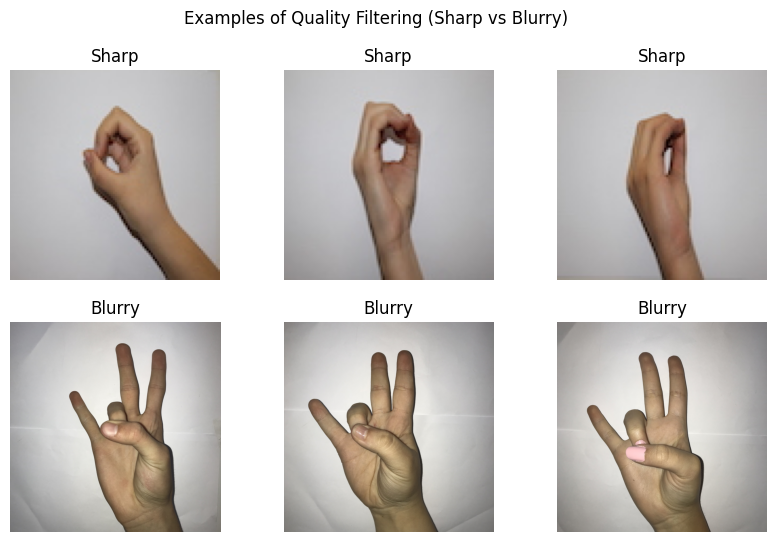

In [14]:
import random

sharp_imgs = [r.path for _, r in manifest.iterrows() if score(cv2.imread(r.path)) > 100][:3]
blurry_imgs = [r.path for _, r in manifest.iterrows() if score(cv2.imread(r.path)) <= 100][:3]

plt.figure(figsize=(10,6))

for i, p in enumerate(sharp_imgs, 1):
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    plt.subplot(2,3,i)
    plt.imshow(img); plt.axis("off"); plt.title("Sharp")

for i, p in enumerate(blurry_imgs, 1):
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    plt.subplot(2,3,i+3)
    plt.imshow(img); plt.axis("off"); plt.title("Blurry")

plt.suptitle("Examples of Quality Filtering (Sharp vs Blurry)")
plt.show()
